In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

Import data and split between years to predict and years to train:

In [ ]:
import random
import numpy as np
from  stellargraph import StellarGraph
import pandas as pd

#load the data
author_codes = np.load("/content/drive/MyDrive/lfnproject/author_codes.npy", allow_pickle = True)
deg = np.load("/content/drive/MyDrive/lfnproject/deg.npy",allow_pickle = True)
har_cen = np.load("/content/drive/MyDrive/lfnproject/har_cen.npy",allow_pickle = True)
deg_cen = np.load("/content/drive/MyDrive/lfnproject/deg_cen.npy",allow_pickle = True)
clos_cen = np.load("/content/drive/MyDrive/lfnproject/clos_cen.npy",allow_pickle = True)
bet_cen = np.load("/content/drive/MyDrive/lfnproject/bet_cen.npy",allow_pickle = True)
load_cen = np.load("/content/drive/MyDrive/lfnproject/load_cen.npy",allow_pickle = True)
square_clus = np.load("/content/drive/MyDrive/lfnproject/square_clus.npy",allow_pickle = True)
pagerank = np.load("/content/drive/MyDrive/lfnproject/pagerank.npy",allow_pickle = True)
constr = np.load("/content/drive/MyDrive/lfnproject/constr.npy",allow_pickle = True)
nodes_index = np.load("/content/drive/MyDrive/lfnproject/nodes_index.npy",allow_pickle = True)
source = np.load("/content/drive/MyDrive/lfnproject/source.npy",allow_pickle = True)

target = np.load("/content/drive/MyDrive/lfnproject/target.npy",allow_pickle = True)
years = np.load("/content/drive/MyDrive/lfnproject/years.npy",allow_pickle = True)
collabs = np.load("/content/drive/MyDrive/lfnproject/collabs.npy",allow_pickle = True)
edge_load_cen = np.load("/content/drive/MyDrive/lfnproject/edge_load_cen.npy",allow_pickle = True)


source_train = []
target_train = []
years_train = []
collabs_train = []
edge_load_cen_train = []

source_test = []
target_test = []
years_test = []
collabs_test = []
edge_load_cen_test = []

for i in range(len(years)):  #use 2003 collaborations as test set
  if(years[i] == 2003):
    years_test.append(years[i])
    source_test.append(source[i])
    target_test.append(target[i])
    collabs_test.append(collabs[i])
    edge_load_cen_test.append(edge_load_cen[i])
  else:
    years_train.append(years[i])
    source_train.append(source[i])
    target_train.append(target[i])
    collabs_train.append(collabs[i])
    edge_load_cen_train.append(edge_load_cen[i])

Split graph into train-val-test:

In [ ]:
square_node_data_train = pd.DataFrame( 
    {"author_code": author_codes,"degree":deg, "harmonic_centrality":har_cen, "degree_centrality":deg_cen, 
    "closeness_centrality": clos_cen, "betweenness_centrality":bet_cen, "load_centrality":load_cen,
     "square_clustering":square_clus, "pagerank": pagerank,  "constraint": constr},
     index = nodes_index)

square_edges_train = pd.DataFrame( 
    {"source": source_train, "target": target_train, "year": years_train, "collab": collabs_train, "load_centrality": edge_load_cen_train}
)

G_train = StellarGraph(square_node_data_train, square_edges_train) 
print(G_train.info())


square_node_data_test = pd.DataFrame( #data structure for the nodes
    {"author_code": author_codes,"degree":deg, "harmonic_centrality":har_cen, "degree_centrality":deg_cen, 
    "closeness_centrality": clos_cen, "betweenness_centrality":bet_cen, "load_centrality":load_cen,
     "square_clustering":square_clus, "pagerank": pagerank,  "constraint": constr},
     index = nodes_index)

square_edges_test = pd.DataFrame( #data structure for the edges
    {"source": source_test, "target": target_test, "year": years_test, "collab": collabs_test, "load_centrality": edge_load_cen_test}
)

G_test = StellarGraph(square_node_data_test, square_edges_test) 
print(G_test.info())

# train, test, validation split
train_size = 0.4 
val_size = 0.1
test_size = 0.05

edge_splitter_test = EdgeSplitter(G_test)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True)

edge_splitter_val = EdgeSplitter(G_train)

G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True)

edge_splitter_train = EdgeSplitter(G_val)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True)

StellarGraph: Undirected multigraph
 Nodes: 15410, Edges: 26702

 Node types:
  default: [15410]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [26702]
        Weights: all 1 (default)
        Features: float32 vector, length 3
StellarGraph: Undirected multigraph
 Nodes: 15410, Edges: 913

 Node types:
  default: [15410]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [913]
        Weights: all 1 (default)
        Features: float32 vector, length 3
** Sampled 45 positive and 45 negative edges. **
** Sampled 2670 positive and 2670 negative edges. **
** Sampled 9612 positive and 9612 negative edges. **


Train the model:

In [ ]:
epochs = 3000

train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

val_gen = FullBatchLinkGenerator(G_val, method="gcn")
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)

test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

gcn = GCN(layer_sizes=[10,16,32,64,16,8,64,512], 
          activations=["softmax","relu","relu","elu","relu","softmax","elu","relu"], generator=train_gen, dropout=0.3)

x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss=keras.losses.binary_crossentropy,metrics=["binary_accuracy"],)
reduce_lr = ReduceLROnPlateau(monitor='binary_accuracy', factor=0.9, patience=50, min_lr=0.0001)
early_stop = EarlyStopping(monitor='binary_accuracy', patience=500)

history = model.fit(
    train_flow,steps_per_epoch = len(train_flow), epochs=epochs,callbacks=[early_stop, reduce_lr], validation_data=val_flow, validation_steps = len(val_flow), verbose=2, shuffle=True)

Output streaming troncato alle ultime 5000 righe.
Epoch 501/3000
1/1 - 0s - loss: 0.5755 - binary_accuracy: 0.6900 - val_loss: 0.5402 - val_binary_accuracy: 0.7097 - lr: 8.1000e-04 - 453ms/epoch - 453ms/step
Epoch 502/3000
1/1 - 0s - loss: 0.5850 - binary_accuracy: 0.6820 - val_loss: 0.5390 - val_binary_accuracy: 0.7107 - lr: 8.1000e-04 - 460ms/epoch - 460ms/step
Epoch 503/3000
1/1 - 0s - loss: 0.5784 - binary_accuracy: 0.6872 - val_loss: 0.5378 - val_binary_accuracy: 0.7110 - lr: 8.1000e-04 - 433ms/epoch - 433ms/step
Epoch 504/3000
1/1 - 0s - loss: 0.5772 - binary_accuracy: 0.6917 - val_loss: 0.5368 - val_binary_accuracy: 0.7109 - lr: 8.1000e-04 - 454ms/epoch - 454ms/step
Epoch 505/3000
1/1 - 0s - loss: 0.5794 - binary_accuracy: 0.6887 - val_loss: 0.5364 - val_binary_accuracy: 0.7107 - lr: 8.1000e-04 - 465ms/epoch - 465ms/step
Epoch 506/3000
1/1 - 0s - loss: 0.5826 - binary_accuracy: 0.6865 - val_loss: 0.5366 - val_binary_accuracy: 0.7107 - lr: 8.1000e-04 - 453ms/epoch - 453ms/step
Ep

Plot the training history:

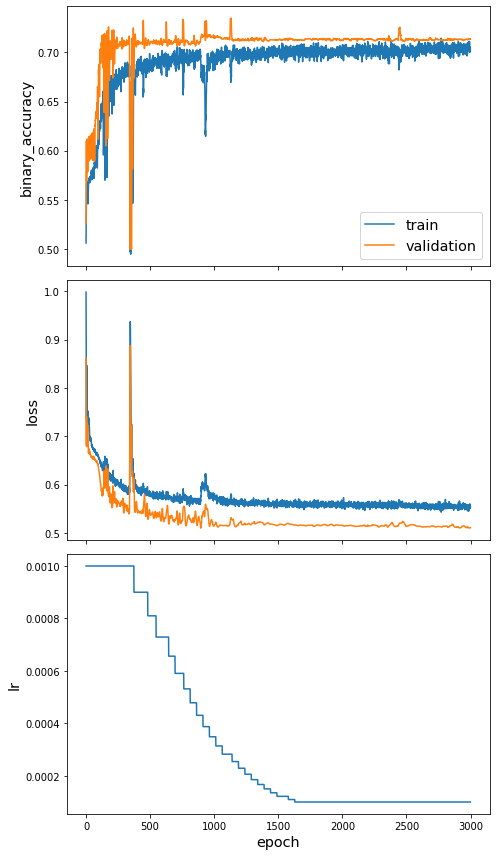

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model:

In [ ]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 94ms/step - loss: 0.5626 - binary_accuracy: 0.8333

Train Set Metrics of the trained model:
	loss: 0.5501
	binary_accuracy: 0.6884

Validation Set Metrics of the trained model:
	loss: 0.5174
	binary_accuracy: 0.7041

Test Set Metrics of the trained model:
	loss: 0.5626
	binary_accuracy: 0.8333
